In [147]:
import numpy as np
import pandas as pd

import scipy.stats as st
# from scipy.stats import skew
# from math import sqrt
# import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly import tools
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
# from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
# from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import ElasticNetCV
# from sklearn.linear_model import BayesianRidge
# from sklearn.linear_model import LassoLarsIC
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
# from sklearn.base import BaseEstimator
# from sklearn.base import TransformerMixin
# from sklearn.base import RegressorMixin
# from sklearn.base import clone
# from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', 
              lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [148]:
def gauss_like(dframes, fitter):
    
    '''If shapiro statistic better after power transformation, 
       apply it to column, else just scale column'''
    
    num_cols = dframes[0].select_dtypes(include=[np.number]).columns
    changed_cols = []
    scaled_cols = []
    
    for col in num_cols:
        t = dframes[0][[col]].copy()
        shapiro_before = st.shapiro(dframes[0][col])[0]
        t = fitter[0].fit_transform(t)
        shapiro_after = st.shapiro(t)[0]
            
        if shapiro_before < shapiro_after:
            dframes[0][col] = t
            
            for df in dframes[1:]:
                df[[col]] = fitter[0].transform(df[[col]])
                
            changed_cols.append(col)
                
        else:
            dframes[0][[col]] = fitter[1].fit_transform(dframes[0][[col]])
            
            for df in dframes[1:]:
                df[[col]] = fitter[1].transform(df[[col]])
                
            scaled_cols.append(col)
    
    print('Transformed columns: ')
    print(*changed_cols, sep=', ')
    print('Scaled columns: ')
    print(*scaled_cols, sep=', ')
    
    return dframes
    

def rmsle_cv(model, X, y):
    
    ''' cross_val_score with shuffled data before splitting. 
        Return Root-Mean-Squared-Error (RMSE) '''
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X.values)
    
    rmse = np.sqrt(-cross_val_score(model, 
                                    X.values, 
                                    y, 
                                    scoring='neg_mean_squared_error', 
                                    cv = kf))
    return(rmse)


def write_to_submission_file(predicted_labels, out_file,
                             target='SalePrice', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index=np.arange(1461, predicted_labels.shape[0] + 1461),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [149]:
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')

In [150]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Outliars

As written in documentation http://jse.amstat.org/v19n3/decock.pdf:

*Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.*

So we can find and delete this outliars.

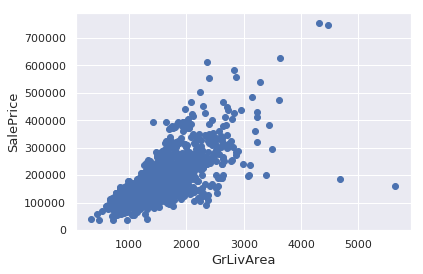

In [151]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We add additional condition in order not to delete unusual sales (very large houses priced relatively appropriately). I have compared, and it worked slightly better.

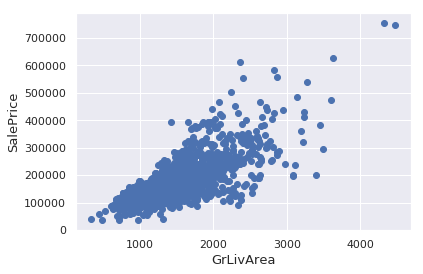

In [152]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & 
                         (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Also we delete some outliers in other features. Deleting outliers below slightly improves scores.  

In [153]:
train = train.drop(train[(train['LotArea']>100000)].index)
train = train.drop(train[(train['MasVnrArea']>1500)].index)
train = train.drop(train[(train['EnclosedPorch']>500)].index)

## Handling missing values

In [154]:
X_train = train.copy()
X_test = test.copy()

y_train = X_train[['SalePrice']]
X_train.drop(['SalePrice'], axis=1, inplace=True)

numerical_columns = X_train.select_dtypes(include=[np.number]).columns
categorical_columsns = X_train.select_dtypes(include=[np.object]).columns

numerical_columns.size + categorical_columsns.size

79

In [155]:
train_null = pd.DataFrame(X_train.isnull().sum()[X_train.isnull().sum() > 0].
                          sort_values(ascending=False), 
                          columns = ['missing'])

train_null

,missing
PoolQC,1447
MiscFeature,1400
Alley,1362
Fence,1172
FireplaceQu,690
LotFrontage,256
GarageYrBlt,81
GarageType,81
GarageFinish,81
GarageQual,81


In [156]:
test_null = pd.DataFrame(X_test.isnull().sum()[X_test.isnull().sum() > 0].
                         sort_values(ascending=False), 
                         columns = ['missing'])

test_null

,missing
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
FireplaceQu,730
LotFrontage,227
GarageYrBlt,78
GarageCond,78
GarageQual,78
GarageFinish,78


Let's make a list of features, where NA means "No something", for eaxmple in feature "Alley" NA means "No alley access"

In [157]:
no_feature_list = np.array(['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                   'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                   'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [158]:
imp_cat = SimpleImputer(missing_values=np.nan, 
                        strategy='constant', 
                        fill_value='no' + no_feature_list)

X_train[no_feature_list] = imp_cat.fit_transform(X_train[no_feature_list])
X_test[no_feature_list] = imp_cat.transform(X_test[no_feature_list])

**LotFrontage:** Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [159]:
imp_num= SimpleImputer(missing_values=np.nan, strategy='mean')

X_train['LotFrontage'] = imp_num.fit_transform(X_train[['LotFrontage']])
X_test['LotFrontage'] = imp_num.transform(X_test[['LotFrontage']])

**GarageYrBlt, GarageArea and GarageCars:** Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [160]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:** missing values are likely zero for having no basement

In [161]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)

**MasVnrArea and MasVnrType:** NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [162]:
X_train['MasVnrType'] = X_train['MasVnrType'].fillna('NoMasVnrType')
X_test['MasVnrType'] = X_test['MasVnrType'].fillna('NoMasVnrType')

X_train['MasVnrArea'] = X_train['MasVnrArea'].fillna(0)
X_test['MasVnrArea'] = X_test['MasVnrArea'].fillna(0)

For the **MSZoning, Utilities, Functional, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType** we can replace missing values with most frequent:

In [163]:
freq_cat = np.array(['MSZoning', 'Utilities', 'Functional', 'Electrical', 
                     'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'], dtype='object')

imp_cat = SimpleImputer(missing_values=np.nan, 
                        strategy='most_frequent')

X_train[freq_cat] = imp_cat.fit_transform(X_train[freq_cat])
X_test[freq_cat] = imp_cat.transform(X_test[freq_cat])

In [167]:
print('Missing values X_train: ' + 
      str(X_train.isnull().sum()[X_train.isnull().sum() > 0].size))

print('Missing values X_test: ' + 
      str(X_test.isnull().sum()[X_test.isnull().sum() > 0].size))



Missing values X_train: 0
Missing values X_test: 0


### Categorical features

In [10]:
# imp_cat = SimpleImputer(missing_values=np.nan, 
#                         strategy='constant', 
#                         fill_value='no' + categorical_columsns)

# X_train[categorical_columsns] = imp_cat.fit_transform(X_train[categorical_columsns])
# X_test[categorical_columsns] = imp_cat.transform(X_test[categorical_columsns])

### Numerical features

In [11]:
# imp_num= SimpleImputer(missing_values=np.nan, strategy='mean')

# X_train[numerical_columns] = imp_num.fit_transform(X_train[numerical_columns])
# X_test[numerical_columns] = imp_num.transform(X_test[numerical_columns])

## Feature normalization

### Visualizations of target

**Skewness and Kurtosis of target**

In [168]:
print('Skewness: {:.4}'.format(y_train.skew()[0]))
print('Kurtosis: {:.4}'.format(y_train.kurt()[0]))

Skewness: 1.9
Kurtosis: 6.638


In [169]:
st.shapiro(y_train)

(0.8680379986763, 2.6383472955817067e-33)

**Target distributions**

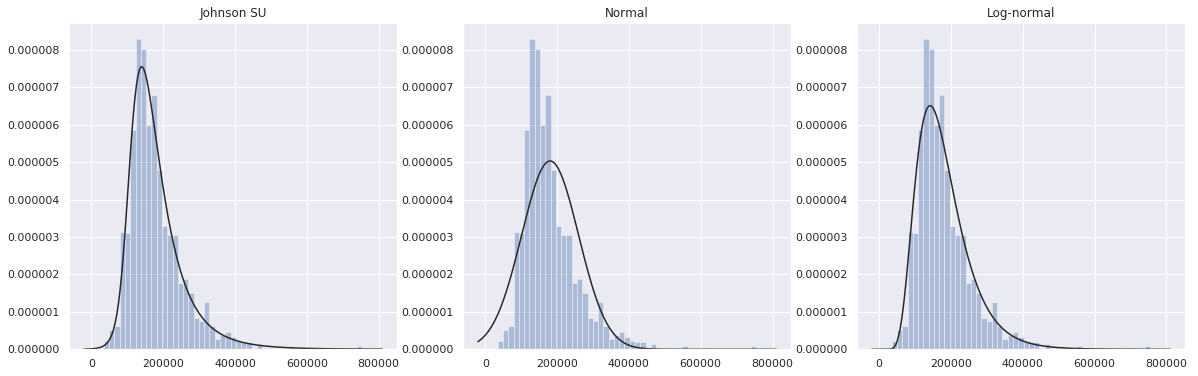

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].set_title('Johnson SU')
axes[1].set_title('Normal')
axes[2].set_title('Log-normal')
sns.distplot(y_train, kde=False, fit=st.johnsonsu, ax=axes[0]);
sns.distplot(y_train, kde=False, fit=st.norm, ax=axes[1]);
sns.distplot(y_train, kde=False, fit=st.lognorm, ax=axes[2]);

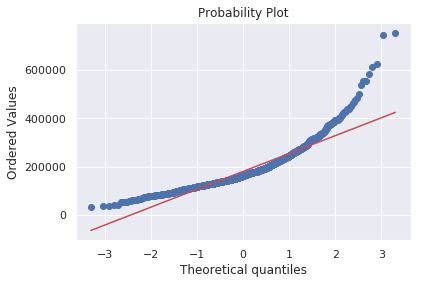

In [171]:
st.probplot(y_train.iloc[:, 0], plot=plt);

**Make target normal again**

In [172]:
pt_target = PowerTransformer(method='yeo-johnson')
y_train['SalePrice'] = pt_target.fit_transform(y_train)
st.shapiro(y_train)

# y_train['SalePrice'] = np.log1p(y_train)
# st.shapiro(y_train)

(0.9913146495819092, 1.4585366159280966e-07)

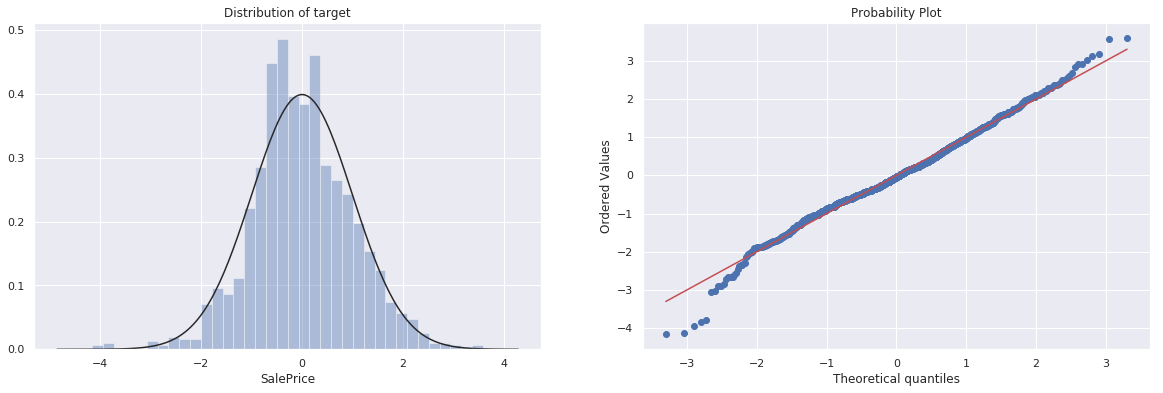

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

axes[0].set_title('Distribution of target')
sns.distplot(y_train['SalePrice'], kde=False, fit=st.norm, ax=axes[0]);
st.probplot(y_train['SalePrice'], plot=axes[1]);

### Normalize numeric features

In [174]:
pt_feat = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()
robust = RobustScaler()
frame_list = gauss_like([X_train, X_test], [pt_feat, scaler])
X_train, X_test = frame_list[0], frame_list[1]

Transformed columns: 
MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF2, BsmtUnfSF, 1stFlrSF, LowQualFinSF, GrLivArea, BedroomAbvGr, TotRmsAbvGrd, GarageYrBlt, GarageCars, OpenPorchSF, 3SsnPorch, ScreenPorch, MiscVal, MoSold, YrSold
Scaled columns: 
BsmtFinSF1, TotalBsmtSF, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, Fireplaces, GarageArea, WoodDeckSF, EnclosedPorch, PoolArea


## Encoding categorical data

In [175]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train = pd.concat([X_train[numerical_columns], 
                     pd.DataFrame(onehot_encoder.
                                  fit_transform(X_train[categorical_columsns]), 
                                  index=X_train.index)], 
                    axis=1)

X_test = pd.concat([X_test[numerical_columns], 
                     pd.DataFrame(onehot_encoder.
                                  transform(X_test[categorical_columsns]), 
                                  index=X_test.index)], 
                    axis=1)

**Save to CSV:**

In [176]:
pd.concat([X_train, y_train], axis=1).to_csv('data/X_train.csv')
X_test.to_csv('data/X_test.csv')

### **We will use parametrs below to tune features and compare results:**

As starting parameters we will use the parameters found after the initial parameter search in kernel 03

Save it as markdown to avoid accidentally erasing

**Lasso:**  
score: 0.1089
alpha=0.0006

**Ridge:**  
score: 0.1119
alpha=18.987

**Elastic:**   
score: 0.1092
l1_ratio=0.6414, alpha=0.001  

**Kernel Ridge:**  
score: 0.1109  
alpha=1.4142, coef0=3, degree=3, kernel='polynomial'

**Gradient Boosting Regression:**  
Score 0.131  
alpha=0.9, learning_rate=0.045, loss=huber, max_depth=18, max_features=0.4, min_samples_leaf=8, min_samples_split=4, n_estimators=100, subsample=0.6} 

**XGB tree:**  
Score 0.11873355586847814  
alpha=0.1, booster=gbtree, colsample_bylevel=0.6, colsample_bynode=0.15, colsample_bytree=0.55, eval_metric='rmse', gamma=0.0, learning_rate=0.095, max_depth=2, min_child_weight=0.2, nthread=-1, num_round=500, objective='reg:linear', reg_lambda=0.85, seed=42, silent=1, subsample=0.8}
	

**XGB linear:**  
score:0.2053561935947925  
alpha=0.1, booster='gblinear', eval_metric='rmse', feature_selector='cyclic', nthread=-1, num_round=500, objective='reg:linear', reg_lambda=0.1, seed=42, silent=1 

**LightGBM:**  
score: 0.11957940856119287  
bagging_freq=6, bagging_seed=42, boosting='gbdt', feature_fraction=0.65, feature_fraction_seed=42, lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.28, max_bin=260, max_depth=3, metric='rmse', min_data_in_leaf=2, min_sum_hessian_in_leaf=1, nthread=4, num_leaves=2, num_round=500, objective='huber', seed=42, subsample=0.75  

# Modelling

We use modified cross_val_score with suffled data before splitting.

## Base models

### Lasso Regression:

In [177]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0006, 
                                            random_state=42))

### Ridge Regression:

In [178]:
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha=18.987, 
                                            random_state=42))

### Elastic Net Regression:

In [179]:
model_ENet = make_pipeline(RobustScaler(), ElasticNet(l1_ratio=0.6414, 
                                                      alpha=0.001, 
                                                      random_state=42))

### Kernel Ridge Regression:

In [180]:
model_KRR = KernelRidge(alpha=1.4142, 
                        coef0=3, 
                        degree=3, 
                        kernel='polynomial')

### Gradient Boosting Regression:

With huber loss that makes it robust to outliers

In [181]:
model_GBoost = GradientBoostingRegressor(n_estimators=100, 
                                         alpha=0.9, 
                                         learning_rate=0.045, 
                                         loss='huber', 
                                         max_depth=18, 
                                         max_features=0.4, 
                                         min_samples_leaf=8, 
                                         min_samples_split=4, 
                                         subsample=0.6, 
                                         n_iter_no_change=100)

### XGBoost tree:

In [182]:
model_xgb = xgb.XGBRegressor(n_estimators=100, 
                             alpha=0.1, 
                             booster='gbtree', 
                             colsample_bylevel=0.6, 
                             colsample_bynode=0.15, 
                             colsample_bytree=0.55, 
                             eval_metric='rmse', 
                             gamma=0.0, 
                             learning_rate=0.095, 
                             max_depth=2, 
                             min_child_weight=0.2, 
                             nthread=-1, 
                             num_round=500, 
                             objective='reg:linear', 
                             reg_lambda=0.85, 
                             seed=42, 
                             silent=1, 
                             subsample=0.8)

### XGBoost linear:

In [183]:
model_xgb_linear = xgb.XGBRegressor(n_estimators=100, 
                                    alpha=0.1, 
                                    booster='gblinear', 
                                    eval_metric='rmse', 
                                    feature_selector='cyclic', 
                                    nthread=-1, 
                                    num_round=500, 
                                    objective='reg:linear', 
                                    reg_lambda=0.1, 
                                    seed=42, 
                                    silent=1)

### LightGBM:

In [184]:
model_lgb = lgb.LGBMRegressor(n_estimators=100, 
                              bagging_freq=6, 
                              bagging_seed=42, 
                              boosting='gbdt', 
                              feature_fraction=0.65, 
                              feature_fraction_seed=42, 
                              lambda_l1=0.1, 
                              lambda_l2=0.1, 
                              learning_rate=0.28, 
                              max_bin=260, 
                              max_depth=3, 
                              metric='rmse', 
                              min_data_in_leaf=2, 
                              min_sum_hessian_in_leaf=1, 
                              nthread=4, 
                              num_leaves=2, 
                              num_round=500, 
                              objective='huber', 
                              seed=42, 
                              subsample=0.75)

**Create dict with scores**

In [185]:
# scores = {'Lasso': np.array(0), 
#           'Ridge': np.array(0), 
#           'ElasticNet': np.array(0), 
#           'Kernel Ridge': np.array(0), 
#           'Gradient Boosting': np.array(0), 
#           'Xgboost': np.array(0), 
#           'Xgboost linear': np.array(0),
#           'LGBM': np.array(0)}

### Base models scores

In [186]:
print("\nLasso previous score: {:.4f} ({:.4f})".format(scores['Lasso'].mean(), 
                                                       scores['Lasso'].std()))

scores['Lasso'] = rmsle_cv(model_lasso, X_train, y_train)

print("Lasso actual score:   {:.4f} ({:.4f})\n".format(scores['Lasso'].mean(), 
                                                       scores['Lasso'].std()))


Lasso previous score: 0.2826 (0.0158)
Lasso actual score:   0.2825 (0.0155)



In [187]:
print("\nRidge previous score: {:.4f} ({:.4f})".format(scores['Ridge'].mean(), 
                                                       scores['Ridge'].std()))

scores['Ridge'] = rmsle_cv(model_ridge, X_train, y_train)

print("Ridge actual score:   {:.4f} ({:.4f})\n".format(scores['Ridge'].mean(), 
                                                       scores['Ridge'].std()))


Ridge previous score: 0.2854 (0.0140)
Ridge actual score:   0.2853 (0.0138)



In [188]:
print("\nElasticNet previous score: {:.4f} ({:.4f})".format(scores['ElasticNet'].mean(), 
                                                            scores['ElasticNet'].std()))

scores['ElasticNet'] = rmsle_cv(model_ENet, X_train, y_train)

print("ElasticNet actual score:   {:.4f} ({:.4f})\n".format(scores['ElasticNet'].mean(), 
                                                            scores['ElasticNet'].std()))



ElasticNet previous score: 0.2815 (0.0158)
ElasticNet actual score:   0.2813 (0.0154)



In [189]:
print("\nKernel Ridge previous score: {:.4f} ({:.4f})".format(scores['Kernel Ridge'].mean(), 
                                                              scores['Kernel Ridge'].std()))
scores['Kernel Ridge'] = rmsle_cv(model_KRR, X_train, y_train)

print("Kernel Ridge actual score:   {:.4f} ({:.4f})\n".format(scores['Kernel Ridge'].mean(), 
                                                              scores['Kernel Ridge'].std()))


Kernel Ridge previous score: 0.2804 (0.0150)
Kernel Ridge actual score:   0.2803 (0.0151)



In [190]:
%%time
print("\nGradient Boosting previous score: {:.4f} ({:.4f})".format(scores['Gradient Boosting'].mean(), 
                                                                   scores['Gradient Boosting'].std()))

scores['Gradient Boosting'] = rmsle_cv(model_GBoost, X_train, y_train)

print("Gradient Boosting actual score:   {:.4f} ({:.4f})\n".format(scores['Gradient Boosting'].mean(), scores['Gradient Boosting'].std()))


Gradient Boosting previous score: 0.3161 (0.0211)
Gradient Boosting actual score:   0.3199 (0.0204)

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.3 s


In [191]:
%%time
print("\nXgboost previous score: {:.4f} ({:.4f})".format(scores['Xgboost'].mean(), 
                                                         scores['Xgboost'].std()))

scores['Xgboost'] = rmsle_cv(model_xgb, X_train, y_train)

print("Xgboost actual score:   {:.4f} ({:.4f})\n".format(scores['Xgboost'].mean(), 
                                                         scores['Xgboost'].std()))


Xgboost previous score: 0.3149 (0.0203)
Xgboost actual score:   0.3185 (0.0189)

CPU times: user 7.59 s, sys: 110 ms, total: 7.7 s
Wall time: 2.24 s


In [192]:
%%time
print("\nXgboost linear previous score: {:.4f} ({:.4f})".format(scores['Xgboost linear'].mean(), 
                                                                scores['Xgboost linear'].std()))

scores['Xgboost linear'] = rmsle_cv(model_xgb_linear, X_train, y_train)

print("Xgboost linear actual score:   {:.4f} ({:.4f})\n".format(scores['Xgboost linear'].mean(), 
                                                                scores['Xgboost linear'].std()))


Xgboost linear previous score: 0.2948 (0.0132)
Xgboost linear actual score:   0.2949 (0.0127)

CPU times: user 11.3 s, sys: 220 ms, total: 11.6 s
Wall time: 3.37 s


In [193]:
%%time
print("\nLGBM previous score: {:.4f} ({:.4f})".format(scores['LGBM'].mean(), 
                                                      scores['LGBM'].std()))

scores['LGBM'] = rmsle_cv(model_lgb, X_train, y_train)

print("LGBM actual score:   {:.4f} ({:.4f})\n".format(scores['LGBM'].mean(), 
                                                      scores['LGBM'].std()))


LGBM previous score: 0.3034 (0.0126)
LGBM actual score:   0.3048 (0.0142)

CPU times: user 6.59 s, sys: 260 ms, total: 6.85 s
Wall time: 2.16 s


# Kaggle score

Let's try to average predictions of this models with untuned parametrs and see score on leaderboard. 

In [220]:
lasso_test = model_lasso.fit(X_train, y_train)
# lasso_test = np.expm1(lasso_test.predict(X_test).reshape(-1, 1))
lasso_test = pt_target.inverse_transform(lasso_test.predict(X_test).reshape(-1, 1))

In [221]:
ridge_test = model_ridge.fit(X_train, y_train)
# ridge_test = np.expm1(ridge_test.predict(X_test).reshape(-1, 1))
ridge_test = pt_target.inverse_transform(ridge_test.predict(X_test).reshape(-1, 1))

In [222]:
elastic_test = model_ENet.fit(X_train, y_train)
# elastic_test = np.expm1(elastic_test.predict(X_test).reshape(-1, 1))
elastic_test = pt_target.inverse_transform(elastic_test.predict(X_test).reshape(-1, 1))

In [223]:
kernel_test = model_KRR.fit(X_train, y_train)
#kernel_test = np.expm1(kernel_test.predict(X_test).reshape(-1, 1))
kernel_test = pt_target.inverse_transform(kernel_test.predict(X_test).reshape(-1, 1))

In [224]:
gb_test = model_GBoost.fit(X_train, y_train)

# gb_test = np.expm1(gb_test.predict(X_test).reshape(-1, 1))
gb_test = pt_target.inverse_transform(gb_test.predict(X_test).reshape(-1, 1))

In [225]:
xgb_test = model_xgb.fit(X_train, y_train)

# xgb_test = np.expm1(xgb_test.predict(X_test).reshape(-1, 1))
xgb_test = pt_target.inverse_transform(xgb_test.predict(X_test).reshape(-1, 1))

In [226]:
xgb_linear_test = model_xgb_linear.fit(X_train, y_train)

# xgb_linear_test = np.expm1(xgb_linear_test.predict(X_test).reshape(-1, 1))
xgb_linear_test = pt_target.inverse_transform(xgb_linear_test.predict(X_test).reshape(-1, 1))

In [227]:
lgb_test = model_lgb.fit(X_train, y_train)

# lgb_test = np.expm1(lgb_test.predict(X_test).reshape(-1, 1))
lgb_test = pt_target.inverse_transform(lgb_test.predict(X_test).reshape(-1, 1))

In [228]:
predicted_test = 0.125 * lasso_test + \
                 0.125 * ridge_test + \
                 0.125 * elastic_test + \
                 0.125 * kernel_test + \
                 0.125 * gb_test + \
                 0.125 * xgb_test + \
                 0.125 * xgb_linear_test + \
                 0.125 * lgb_test


In [229]:
write_to_submission_file(predicted_test, 'house_pricing_submission.csv')

The score is 0.11667, previous test score was 0.11629